In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
from typing import List, Tuple, Optional
from dataclasses import dataclass

# local imports


from story_data_loader import StoryDataset, generate_batches

In [2]:
@dataclass
class Args:
    file_path = 'data/TinyStories-valid.txt'
    tokenizer_path = "tokenizer.model"
    frequency_cutoff=25

    # Needed for KV cache
    batch_size: int = 128
    context_window: int = 16
    early_stopping_criteria :int = 5
    learning_rate: float = 0.001
    seed: int = 1337
    num_epochs: int = 10
    vocab_size: int = -1  # set after tokenizer is loaded
    d_model: int = 128
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    cuda: bool = True

# Loss Function


In [3]:
# Compute accuracy function
def compute_accuracy(y_pred, y_target):
    y_target = y_target.cpu()
    y_pred_indices = y_pred.argmax(dim=-1).cpu()
    # y_pred_indices = (torch.sigmoid(y_pred)>0.5).cpu().long()#.max(dim=1)[1]

    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) #* 100

### Model

In [4]:
class SimpleBrokenModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(self.config.vocab_size, self.config.d_model)
        self.linear = nn.Sequential(
            nn.Linear(self.config.d_model, self.config.d_model),
            nn.ReLU(),
            nn.Linear(self.config.d_model, self.config.vocab_size),
        )

        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        logits = self.linear(x)
        # logits = F.softmax(a, dim=-1)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.config.vocab_size), targets.view(-1))
            return logits, loss

        else:
            return logits

### Setting State

In [17]:
import torch.optim as optim
def make_train_state():
    return {'epoch_index': 0,
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'test_loss': 1,
        'test_acc': 1}

train_state = make_train_state()
if not torch.cuda.is_available(): Args.cuda = False

Args.device = torch.device("cuda" if Args.cuda else "cpu")
# dataset and vectorizer
dataset = StoryDataset.load_dataset_and_tokenizer(Args.file_path, Args.tokenizer_path, context_window=Args.context_window)
tokenizer = dataset.get_tokenizer()
Args.vocab_size = tokenizer.vocab_size()
print("Vocab size:", Args.vocab_size)
# model
model = model = SimpleBrokenModel(Args)
model = model.to(Args.device)
# optimizer
optimizer = optim.Adam(model.parameters())#, lr=Args.learning_rate)

Vocab size: 32000
model params: 8240512


In [6]:
len(dataset)

73733

In [7]:
train_state = make_train_state()
train_loss = []
val_loss = []
for epoch_index in range(Args.num_epochs):
    train_state['epoch_index'] = epoch_index
    # Iterate over training dataset
    # setup: batch generator, set loss and acc to 0, set train mode on

    dataset.set_split('train')
    batch_generator = generate_batches(dataset,
                            batch_size=Args.batch_size,
                            device=Args.device)
    running_loss = 0.0
    running_acc = 0.0
    

    model.train()
    for batch_index, batch_dict in enumerate(batch_generator):
        # the training routine is 5 steps:
        # step 1. zero the gradients
        optimizer.zero_grad()
        # step 2. compute the output
        xs, ys = batch_dict['x_data'], batch_dict['y_target']
        logits, loss = model(xs, ys)
        # y_pred = model(x_in=batch_dict['x_data'].float())
        # step 3. compute the loss
        # loss = loss_func(y_pred, batch_dict['y_target'].float())
        loss_batch = loss.item()
        running_loss += ((loss_batch - running_loss) / (batch_index + 1))
        # step 4. use loss to produce gradients
        loss.backward()
        # step 5. use optimizer to take gradient step
        optimizer.step()

        train_loss.append(loss_batch) # -> appending every single loss
        # compute the accuracy
        acc_batch = compute_accuracy(logits, batch_dict['y_target'])
        running_acc += (acc_batch - running_acc) / (batch_index + 1)

    train_state['train_loss'].append(running_loss)
    train_state['train_acc'].append(running_acc)


    # Iterate over val dataset
    # setup: batch generator, set loss and acc to 0, set eval mode on
    dataset.set_split('val')

    batch_generator = generate_batches(dataset,
                        batch_size=Args.batch_size,
                        device=Args.device)
    running_loss = 0.0
    running_acc = 0.0
    model.eval()
    for batch_index, batch_dict in enumerate(batch_generator):
        # step 1. compute the output
        xs, ys = batch_dict['x_data'], batch_dict['y_target']
        logits, loss = model(xs, ys)
        # step 2. compute the loss
        loss_batch = loss.item()
        running_loss += (loss_batch - running_loss) / (batch_index + 1)
        val_loss.append(loss_batch) # -> appending every single loss
        # step 3. compute the accuracy
        acc_batch = compute_accuracy(logits, batch_dict['y_target'])
        running_acc += (acc_batch - running_acc) / (batch_index + 1)
    train_state['val_loss'].append(running_loss)
    train_state['val_acc'].append(running_acc)


In [8]:
train_state['train_loss']

[4.084742911573915,
 3.0076944120228317,
 2.8738888771169724,
 2.8211893157826533,
 2.7918751674393785,
 2.7772550798124724,
 2.7659898917708126,
 2.762291771256264,
 2.759237796482113,
 2.7562809085680344]

In [9]:
train_state['val_loss']

[4.121997756543366,
 4.2300502362458605,
 4.333093858801798,
 4.422752003047777,
 4.520990981226385,
 4.587553866013237,
 4.637843948861826,
 4.671745258828871,
 4.712726311061692,
 4.726848287167756]

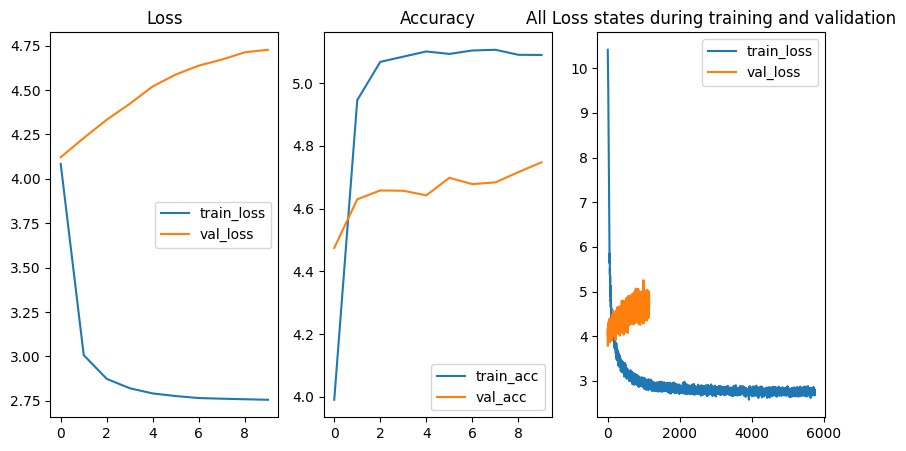

In [13]:
# plto 3 plots in subplots
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.plot(train_state['train_loss'], label='train_loss')
plt.plot(train_state['val_loss'], label='val_loss')
plt.title("Loss")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_state['train_acc'], label='train_acc')
plt.plot(train_state['val_acc'], label='val_acc')
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(train_loss, label='train_loss')
plt.plot(val_loss, label='val_loss')
plt.title("All Loss states during training and validation")
plt.legend()




plt.show()

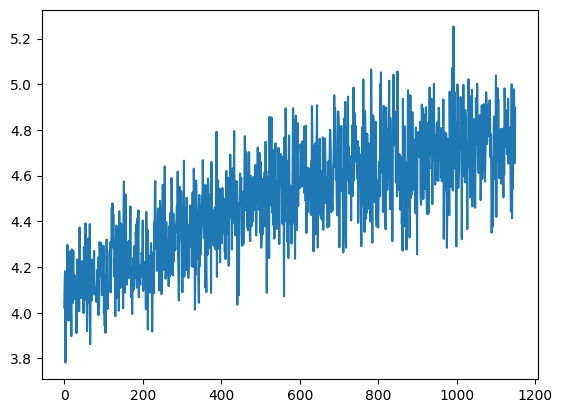

In [16]:
plt.plot(val_loss)

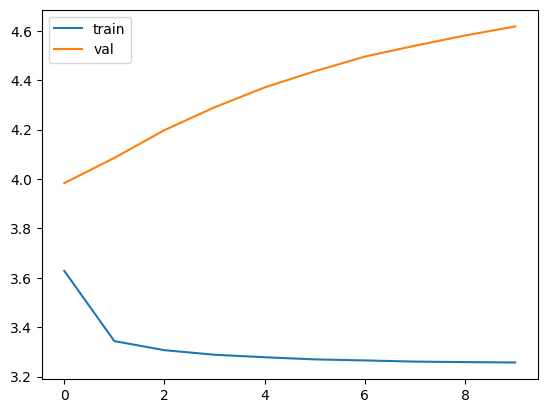

In [10]:
import matplotlib.pyplot as plt
plt.plot(train_state['train_loss'], label='train')
plt.plot(train_state['val_loss'], label='val')
plt.legend()
plt.show()

In [15]:
len(val_loss)
len(train_loss)

5760

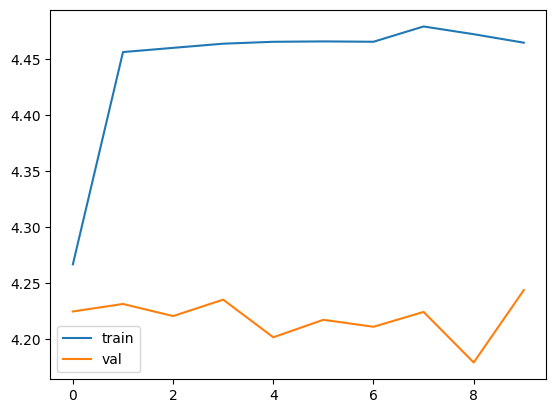

In [11]:
import matplotlib.pyplot as plt
plt.plot(train_state['train_acc'], label='train')
plt.plot(train_state['val_acc'], label='val')
plt.legend()
plt.show()

### Testing

In [11]:
dataset.set_split('test')
batch_generator = generate_batches(dataset,
batch_size=Args.batch_size,
device=Args.device)
running_loss = 0.
running_acc = 0.
model.eval()
for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    xs, ys = batch_dict['x_data'], batch_dict['y_target']
    logits, loss = model(xs, ys)
    # compute the loss
    loss_batch = loss.item()
    running_loss += (loss_batch - running_loss) / (batch_index + 1)
    # compute the accuracy
    acc_batch = compute_accuracy(logits, batch_dict['y_target'])
    running_acc += (acc_batch - running_acc) / (batch_index + 1)
train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc

In [12]:
print(f"Testing Loss: {train_state['test_loss']}")
print(f"Testing Acc: {train_state['test_acc']}")

5.013766184361022

In [ ]:
def generate(model, config=Args, max_new_tokens=30):
    idx = torch.zeros(5, 1).long()
    for _ in range(max_new_tokens):
        # call the model
        logits = model(idx[:, -config.context_window:])
        last_time_step_logits = logits[
            :, -1, :
        ]  # all the batches (1), last time step, all the logits
        p = F.softmax(last_time_step_logits, dim=-1)  # softmax to get probabilities
        idx_next = torch.multinomial(
            p, num_samples=1
        )  # sample from the distribution to get the next token
        idx = torch.cat([idx, idx_next], dim=-1)  # append to the sequence
    return [tokenizer.decode(x) for x in idx.tolist()]

generate(model)